# <center> Plotting/Optimizing Radial Velocities and Lightcurve for KIC 4569590 <center>

## Import Modules 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%pylab qt5
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read in RV data from github file

In [3]:
t, srv, serr, prv, perr = np.loadtxt('4569590.dat', delimiter=';', unpack=True)
#print t, prv, perr, srv, serr

#Define variables from Villanova
p = 41.3701999
t_pe = 55039.730861-54833

## Phase Data (fold lightcurve to get more data points for each eclipse)
$ phase= \frac{(t-t_{pe})\%p}{p}$

In [3]:
phase = ((t-t_pe)%p)/p
#print phase

## Plot Radial Velocities

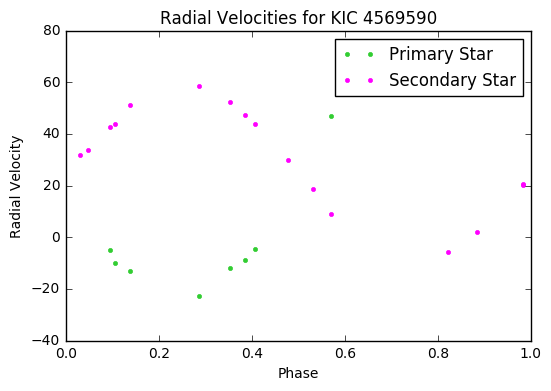

In [15]:
plt.figure()
plt.title('Radial Velocities for KIC 4569590')
plt.plot(phase, prv, '.', color='limegreen', label='Primary Star')
plt.plot(phase, srv, '.', color='fuchsia', label='Secondary Star')
plt.xlabel('Phase')
plt.ylabel('Radial Velocity')
plt.legend()
plt.show();

# Finding Individual Masses

### Write function to find indivudual masses

In [5]:
pi = np.pi
e = 0 #(assume zero eccentricity for now)

def find_Masses(k1, k2, p, e=0):
    alpha = (2*pi*6.67e-11)/((p*3600*24)*(1-e**2)**1.5)
    x = k2/k1
    y = k1/k2
    m1 = (y/(1+x)**2) + (1/((1+y)**2))
    m1 = m1 * alpha
    m1 = (k1**3 + k2**3)/m1
    m2 = y * m1
    return m1, m2

### Use function to find individual masses

In [6]:
#Estimated offset from RV plot: 22.19
m1, m2 = find_Masses((70.6-22.19)*1e3, (59-22.19)*1e3, p, e=.3)
#print m1, m2

#Put into solar masses 
M1 = m1 / (1.99e30)
M2 = m2 / (1.99e30)
print M1, M2

0.994611666003 1.30804538851


## Switch to Lightcurves
### Run Script to begin optimizing lightcurves

In [7]:
run apogee_lcs.py 4569590

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Isodata.cat already exists; loaded.
LC data for KIC 4569590 loaded.
Excluding  []
Clip tolerance = 1.0


## Making initial guesses for lightcurve parameters and create model using keblat.lcfit

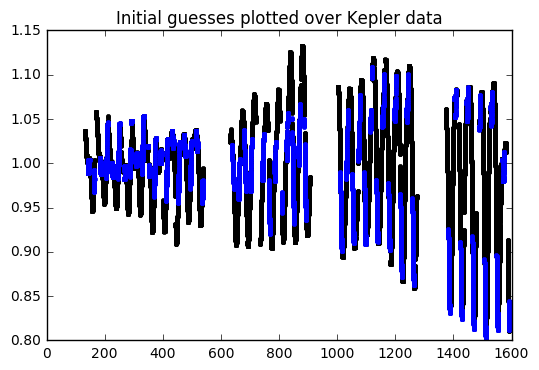

In [8]:
#List of lc parameters includes: [msum, rsum, rrat, period, tpe, esinw, ecosw, b, frat, q1, q2, q3, q4]

lcpars= [M1+M2, 15, 8.3, period, t_pe, esinw, ecosw, .02, 40, q1, q2, q3, q4]
model_fluxes, model_polynomials = keblat.lcfit(lcpars, keblat.jd[keblat.clip], keblat.quarter[keblat.clip], keblat.flux[keblat.clip], keblat.dflux[keblat.clip], keblat.crowd[keblat.clip], polyorder=2)

plt.title('Initial guesses plotted over Kepler data')
plt.plot(keblat.jd, keblat.flux, "k.")
plt.plot(keblat.jd[keblat.clip], model_fluxes*model_polynomials, ".")
plt.show()

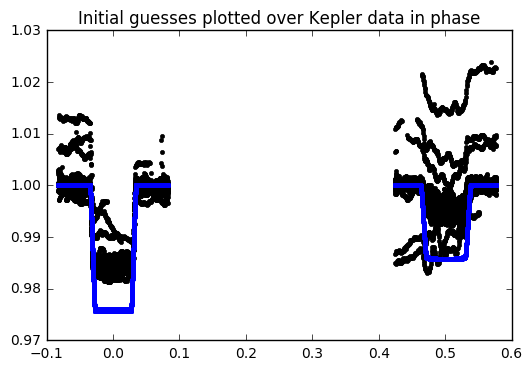

In [9]:
plt.title('Initial guesses plotted over Kepler data in phase')
plt.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/model_polynomials, "k.")
plt.plot(keblat.phase[keblat.clip], model_fluxes, ".")
plt.show()

## Optimizing the lightcurve

In [10]:
#Refine the parameter bounds based on initial guesses to help optimizer
keblat.parbounds['b'][1]=0.2
keblat.parbounds['ecosw']=[-0.1, 0.1]
keblat.parbounds['esinw']=[-0.1, 0.1]
keblat.parbounds['period']=[0.99*period, 1.01*period]
keblat.parbounds['tpe'] = [0.99*t_pe, 1.01*t_pe]

In [11]:
opt_lcpars0 = opt_lc(msum=M1+M2, rsum=15, rrat=1/0.12, period=period, tpe=t_pe, esinw=esinw,
                             ecosw=ecosw, b=0.02, frat=40, q1=q1, q2=q2, q3=q3, q4=q4)

==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 63
    # data points      = 15909
    # variables        = 7
    chi-square         = 42001198.492
    reduced chi-square = 2641.253
    Akaike info crit   = 125354.145
    Bayesian info crit = 125407.868
[[Variables]]
    q1:       0.01 (fixed)
    q2:       0.01 (fixed)
    tpe:      206.714430 +/- 0.003962 (0.00%) (init= 206.7309)
    b:        0.07009883 +/- 34.93423 (49835.68%) (init= 0.02)
    ecosw:    0.00047799 +/- 0.000308 (64.36%) (init= 0.001256637)
    q4:       0.01 (fixed)
    rsum:     13.9422184 +/- 0.482758 (3.46%) (init= 15)
    period:   41.3702 (fixed)
    q3:       0.01 (fixed)
    msum:     2.302657 (fixed)
    frat:     79.9188595 +/- 0.600297 (0.75%) (init= 40)
    rrat:     12.0216975 +/- 0.085526 (0.71%) (init= 8.333333)
    esinw:   -0.01153793 +/- 0.003376 (29.26%) (init= 0.04106128)
[[Correlations]] (unreported correlations are <  0.100)
 

## Plotting optimized parameters over Keplar data

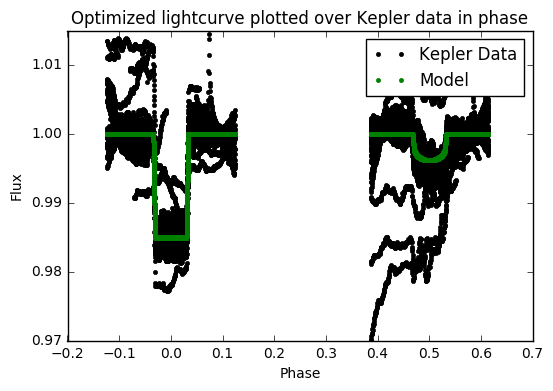

In [16]:
#Have to update keblat.phase becuase t_pe was changed in optimizer
keblat.updatephase(opt_lcpars0[4], opt_lcpars0[3], clip_tol=1.5)

#Use keblat.lcfit to store optimized model fluxes and polynomials
opt_modelfluxes, opt_modelpolynomials = keblat.lcfit(opt_lcpars0, keblat.jd[keblat.clip], keblat.quarter[keblat.clip], keblat.flux[keblat.clip], keblat.dflux[keblat.clip], keblat.crowd[keblat.clip], polyorder=2)

plt.title('Optimized lightcurve plotted over Kepler data in phase')
plt.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/opt_modelpolynomials, "k.", label='Kepler Data')
plt.plot(keblat.phase[keblat.clip], opt_modelfluxes, "g.", label='Model')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [17]:
#Print optimized lightcurves
keblat.pars

OrderedDict([('m1', None),
             ('m2', None),
             ('z0', None),
             ('age', None),
             ('dist', None),
             ('ebv', None),
             ('h0', None),
             ('period', 41.370759742016553),
             ('tpe', 206.70523514925551),
             ('esinw', -0.010745546685110935),
             ('ecosw', 0.0009313485169206992),
             ('b', 0.00027340095988591661),
             ('q1', 1.5916004323324184e-05),
             ('q2', 0.05113579850519645),
             ('q3', 0.35263982862128318),
             ('q4', 0.4170171481677542),
             ('lcerr', None),
             ('isoerr', None),
             ('k0', None),
             ('rverr', None),
             ('msum', 1.4240098798638858),
             ('mrat', None),
             ('rsum', 11.887952295433992),
             ('rrat', 17.577518697680933),
             ('r1', 0.63991066239206573),
             ('r2', 11.248041633041927),
             ('inc', 1.5707932385712382),
           

# Optimizing Radial Velocities
## Prep for optimization by finding masses from the RV semi-amplitudes using keblat.rvprep

In [23]:
#takes in (t, rv1, rv2, drv1, drv2)
#returns (m1, m2, k0)
keblat.rvprep(t, prv*1e3, srv*1e3, perr*1e3, serr*1e3)

(0.8430253920963966, 1.2108814766650702, 25210.0)

## Re-phase and plot RV data 

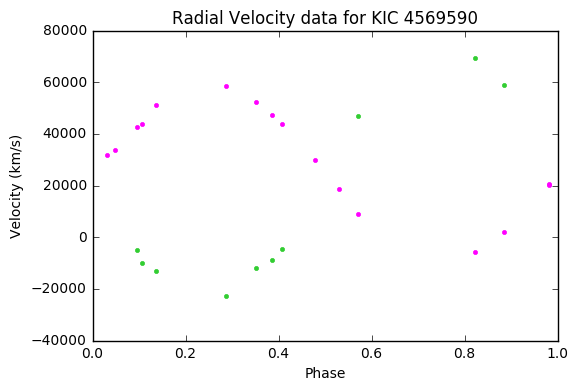

In [44]:
#Have to phase the data again becuase parameters have changed from optimization
phase2 = ((keblat.rv_t-keblat.pars['tpe'])%keblat.pars['period'])/keblat.pars['period']

plt.title('Radial Velocity data for KIC 4569590')
plt.plot(phase2, keblat.rv1_obs, '.', color='limegreen')
plt.plot(phase2, keblat.rv2_obs, '.', color='fuchsia')
plt.xlabel('Phase')
plt.ylabel('Velocity (km/s)');

## Make RV model with keblat.rvfit and plot against data

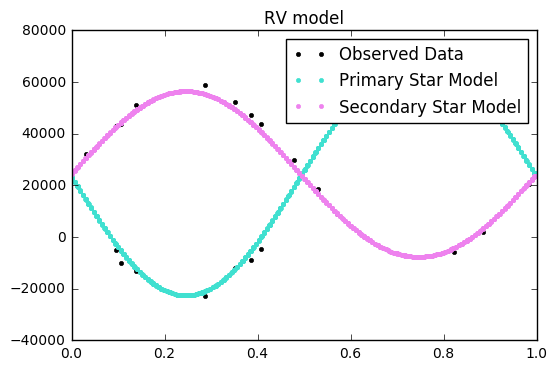

In [52]:
#Create more data points to see model clearly
tmod = np.linspace(keblat.rv_t[0], keblat.rv_t[-1], 1000)
phasemod = ((tmod - keblat.pars['tpe'])%keblat.pars['period'])/keblat.pars['period']

rv1_mod, rv2_mod = keblat.rvfit([0.84+1.205, 1.205/0.84, keblat.pars['period'], keblat.pars['tpe'], 
                                 .0001, keblat.pars['ecosw'],
                                 keblat.pars['inc'], 24*1e3, 0.0], tmod)

plt.title('RV model')
plt.plot(phase2, keblat.rv1_obs, 'k.', label='Observed Data')
plt.plot(phase2, keblat.rv2_obs, 'k.')
plt.plot(phasemod, rv1_mod, '.', color='turquoise', label='Primary Star Model')
plt.plot(phasemod, rv2_mod, '.', color='violet', label='Secondary Star Model')
plt.legend();

## Optimize RV model

In [48]:
#Restrict parameter bounds based on previous model 
keblat.parbounds['mrat']=[0.0085, 10.]

opt_rvpars = opt_rv(msum=0.84+1.205, mrat=1.205/0.84, period=period, tpe=tpe, 
       esinw=.0001, ecosw=0.0009313, inc=1.57079, k0=24*1e3, rverr=0.0)

rverr 0.0
tpe 206.730861
ecosw 0.0009313
mrat 1.43452380952
period 41.3701999
msum 2.045
k0 24000.0
esinw 0.0001
inc 1.57079
========================= Starting RV ONLY fit... ========================
Parameters([('rverr', <Parameter 'rverr', value=0.0 (fixed), bounds=[0.0:10000.0]>), ('tpe', <Parameter 'tpe', value=206.73086099999637 (fixed), bounds=[204.6635523899964:208.79816960999634]>), ('ecosw', <Parameter 'ecosw', 0.0009313, bounds=[-0.1:0.1]>), ('mrat', <Parameter 'mrat', 1.4345238095238098, bounds=[0.0085:10.0]>), ('period', <Parameter 'period', value=41.370199900000003 (fixed), bounds=[40.956497901000006:41.783901899]>), ('msum', <Parameter 'msum', 2.045, bounds=[0.2:24.0]>), ('k0', <Parameter 'k0', 24000.0, bounds=[-100000000.0:100000000.0]>), ('esinw', <Parameter 'esinw', 0.0001, bounds=[-0.1:0.1]>), ('inc', <Parameter 'inc', 1.57079, bounds=[0.0:1.5707963267948966]>)])
28.0102605073 36.4131057241
[[Fit Statistics]]
    # function evals   = 78
    # data points      = 26
   

## Create model out of optimized parameters and plot over data

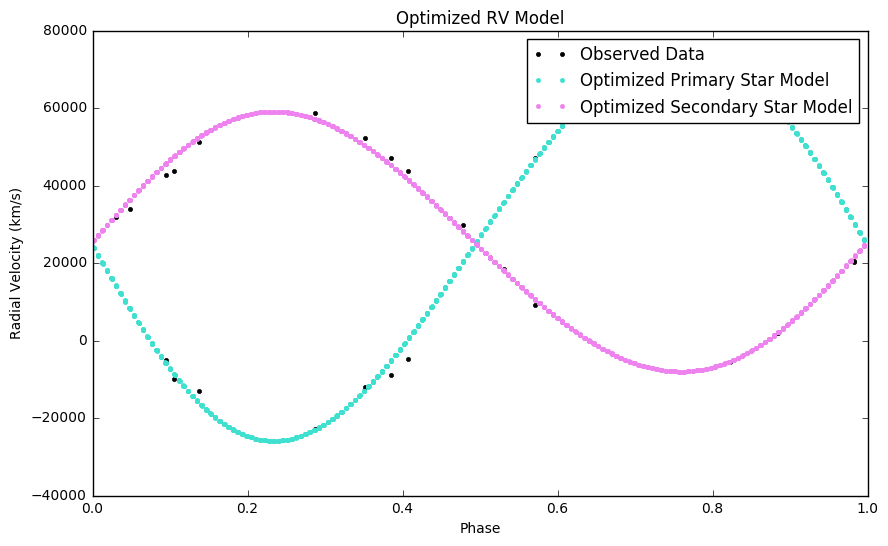

In [61]:
opt_rv1_mod, opt_rv2_mod = keblat.rvfit(opt_rvpars, tmod)

plt.figure(figsize=(10,6))
plt.title('Optimized RV Model')
plt.plot(phase2, keblat.rv1_obs, 'k.', label='Observed Data')
plt.plot(phase2, keblat.rv2_obs, 'k.')
plt.plot(phasemod, opt_rv1_mod, '.', color='turquoise', label='Optimized Primary Star Model')
plt.plot(phasemod, opt_rv2_mod, '.', color='violet', label='Optimized Secondary Star Model')
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Radial Velocity (km/s)');

## Optimize lightcurve and radial velocities simultaneously

In [63]:
#Restrict parameter bounds based on last optimization
keblat.parbounds['msum'] = [2.3, 2.8]

opt_lcrvpars=opt_lcrv(msum=opt_rvpars[0], mrat=opt_rvpars[1], rsum=opt_lcpars0[1], rrat=opt_lcpars0[2], period=opt_lcpars0[3], tpe=opt_lcpars0[4], esinw=opt_lcpars0[5],ecosw=opt_lcpars0[6],b=opt_lcpars0[7], frat= opt_lcpars0[8], q1=opt_lcpars0[9], q2=opt_lcpars0[10], q3 = opt_lcpars0[11], q4=opt_lcpars0[12], lcerr=0, k0=opt_rvpars[-2], rverr=0)

================= Starting LC + RV simultaneous fit... ===================
1478.21218895 1471.63356212
[[Fit Statistics]]
    # function evals   = 189
    # data points      = 23931
    # variables        = 17
    chi-square         = 35192645.004
    reduced chi-square = 1471.634
    Akaike info crit   = 174572.779
    Bayesian info crit = 174710.189
[[Variables]]
    q1:       1.6570e-05 +/- 0        (0.00%) (init= 1.5916e-05)
    q2:       5.8205e-05 +/- 0        (0.00%) (init= 0.0511358)
    tpe:      206.701238 +/- 0        (0.00%) (init= 206.7052)
    b:        0.00269955 +/- 0        (0.00%) (init= 0.000273401)
    ecosw:    0.00226941 +/- 0        (0.00%) (init= 0.0009313485)
    q4:       0.74930636 +/- 0        (0.00%) (init= 0.4170171)
    rsum:     12.5657099 +/- 0        (0.00%) (init= 11.88795)
    mrat:     1.54195008 +/- 0        (0.00%) (init= 1.500584)
    period:   41.3710374 +/- 0        (0.00%) (init= 41.37076)
    q3:       0.13892126 +/- 0        (0.00%) (init= 0

## Make plots of simultaneuos LC RV fits

True

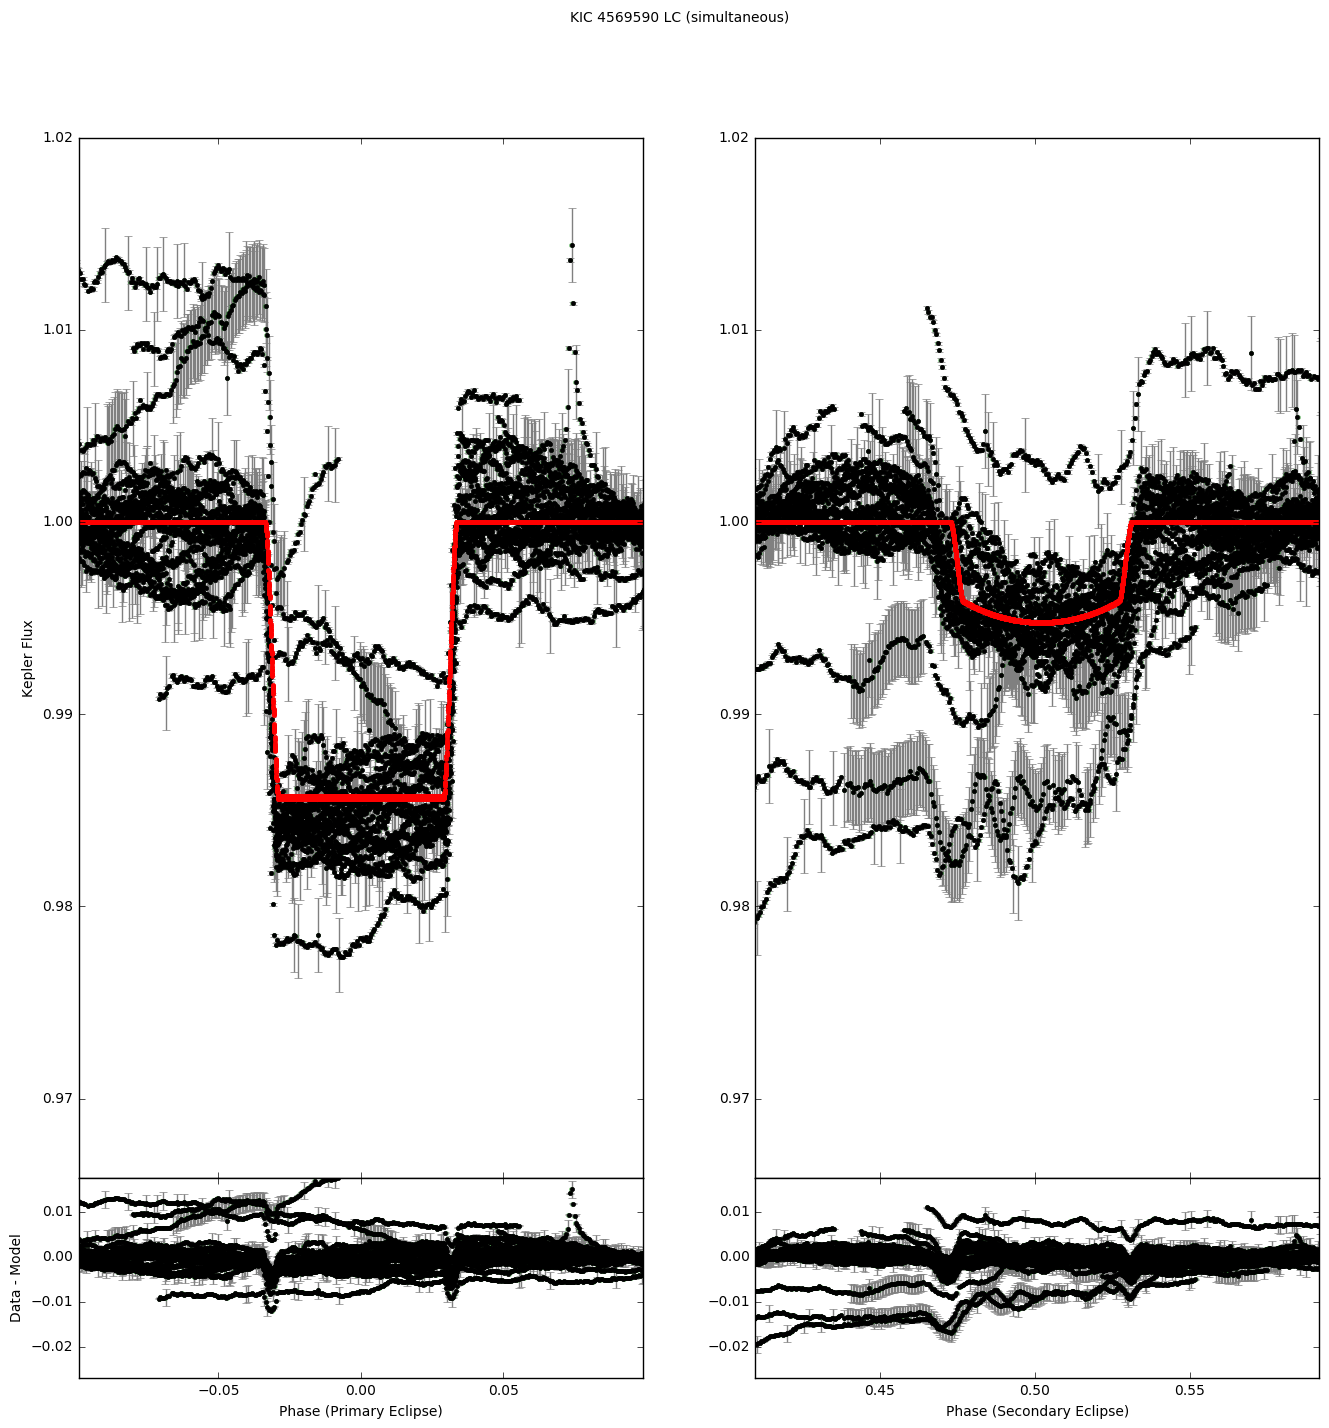

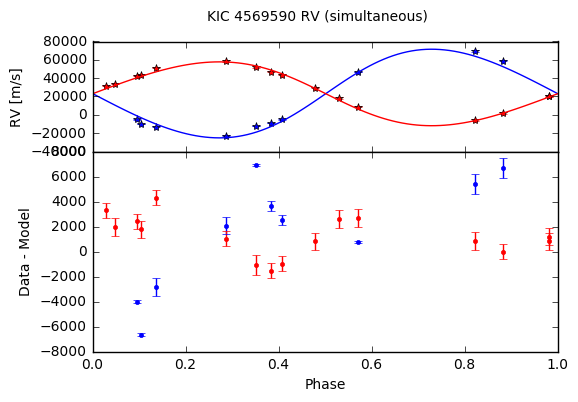

In [67]:
make_lcrv_plots(kic, opt_lcrvpars, '', suffix='', savefig=False, polyorder=2)

In [66]:
print opt_lcrvpars

[  2.44721971e+00   1.38869678e+00   1.32434799e+01   1.45647732e+01
   4.13713336e+01   2.06695073e+02  -6.85915667e-02   3.15478860e-03
   3.41186848e-02   6.79764176e+01   1.37718455e-02   6.57751813e-02
   7.04958509e-02   8.90939383e-01   0.00000000e+00   2.30678952e+04
   0.00000000e+00]
